In [ ]:
!git clone https://github.com/SwaroopMeher/NIDS.git

Cloning into 'NIDS'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 46
Unpacking objects: 100% (50/50), done.
Checking out files: 100% (62/62), done.


In [ ]:
!pwd

/content


In [ ]:
!cd Network-Intrusion-Detection/

/bin/bash: line 0: cd: Network-Intrusion-Detection/: No such file or directory


In [ ]:
!ls

NIDS  sample_data


In [ ]:
import pandas as pd
import numpy as np
import sys
import sklearn
from IPython.display import Image  
from sklearn import tree
import pydotplus

In [ ]:
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]

# KDDTrain+_2.csv & KDDTest+_2.csv are the datafiles without the last column about the difficulty score
# these have already been removed.
df = pd.read_csv("NIDS/KDDTrain+_2.csv", header=None, names = col_names)
df_test = pd.read_csv("NIDS/KDDTest+_2.csv", header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [ ]:
print(df.head)

<bound method NDFrame.head of         duration protocol_type  ... dst_host_srv_rerror_rate    label
0              0           tcp  ...                     0.00   normal
1              0           udp  ...                     0.00   normal
2              0           tcp  ...                     0.00  neptune
3              0           tcp  ...                     0.01   normal
4              0           tcp  ...                     0.00   normal
...          ...           ...  ...                      ...      ...
125968         0           tcp  ...                     0.00  neptune
125969         8           udp  ...                     0.00   normal
125970         0           tcp  ...                     0.00   normal
125971         0           tcp  ...                     0.00  neptune
125972         0           tcp  ...                     0.00   normal

[125973 rows x 42 columns]>


In [ ]:

print('Label distribution Training set:')
print(df['label'].value_counts())
print()
print('Label distribution Test set:')
print(df_test['label'].value_counts())

Label distribution Training set:
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64

Label distribution Test set:
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178


In [ ]:

# colums that are categorical and not binary yet: protocol_type (column 2), service (column 3), flag (column 4).
# explore categorical features
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

#see how distributed the feature service is, it is evenly distributed and therefore we need to make dummies for all.
print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [ ]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [ ]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
categorical_columns=['protocol_type', 'service', 'flag']
# insert code to get a list of categorical columns into a variable, categorical_columns
categorical_columns=['protocol_type', 'service', 'flag'] 
 # Get the categorical values into a 2D numpy array
df_categorical_values = df[categorical_columns]
testdf_categorical_values = df_test[categorical_columns]
df_categorical_values.head()

,protocol_type,service,flag
0,tcp,ftp_data,SF
1,udp,other,SF
2,tcp,private,S0
3,tcp,http,SF
4,tcp,http,SF


In [ ]:

# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2
print(dumcols)

#do same for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2

['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp', 'service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'serv

In [ ]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [ ]:
enc = OneHotEncoder()
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

df_cat_data.head()

,Protocol_type_icmp,Protocol_type_tcp,Protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]
difference

['service_harvest',
 'service_http_2784',
 'service_urh_i',
 'service_aol',
 'service_red_i',
 'service_http_8001']

In [ ]:
for col in difference:
    testdf_cat_data[col] = 0

testdf_cat_data.shape

(22544, 84)

In [ ]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)
# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)
print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [ ]:
# take label column
label_df=newdf['label']
label_df_test=newdf_test['label']
# change the label column
new_label_df=label_df.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 
                            'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 
                            'apache2': 1, 'processtable': 1, 'udpstorm': 1, 
                            'worm': 1, 'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,
                            'satan' : 2,'mscan' : 2,'saint' : 2,
                            'ftp_write': 3,'guess_passwd': 3,'imap': 3,
                            'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,
                            'warezmaster': 3,'sendmail': 3,'named': 3,
                            'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,
                            'xsnoop': 3,'httptunnel': 3, 'buffer_overflow': 4,
                            'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,
                            'sqlattack': 4,'xterm': 4})

new_label_df_test=label_df_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1,
                                      'land': 1, 'pod': 1, 'smurf': 1, 
                                      'teardrop': 1,'mailbomb': 1, 'apache2': 1,
                                      'processtable': 1, 'udpstorm': 1, 
                                      'worm': 1, 'ipsweep' : 2,'nmap' : 2,
                                      'portsweep' : 2,'satan' : 2,'mscan' : 2,
                                      'saint' : 2, 'ftp_write': 3,
                                      'guess_passwd': 3,'imap': 3,'multihop': 3,
                                      'phf': 3,'spy': 3,'warezclient': 3,
                                      'warezmaster': 3,'sendmail': 3,'named': 3,
                                      'snmpgetattack': 3,'snmpguess': 3,
                                      'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                                      'buffer_overflow': 4,'loadmodule': 4,
                                      'perl': 4,'rootkit': 4,'ps': 4,
                                      'sqlattack': 4,'xterm': 4})

# put the new label column back
newdf['label'] = new_label_df
newdf_test['label'] = new_label_df_test
print(newdf['label'].head())

0    0
1    0
2    1
3    0
4    0
Name: label, dtype: int64


In [ ]:
to_drop_DoS = [2,3,4]
to_drop_Probe = [1,3,4]
to_drop_R2L = [1,2,4]
to_drop_U2R = [1,2,3]
DoS_df=newdf[~newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[~newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[~newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[~newdf['label'].isin(to_drop_U2R)];

#test
DoS_df_test=newdf_test[~newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[~newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[~newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[~newdf_test['label'].isin(to_drop_U2R)];
print('Train:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print('Test:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)
Test:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


In [ ]:
# Split dataframes into X & Y

X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label
X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label
X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label
X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label
# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

In [ ]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [ ]:
from sklearn import preprocessing
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 
# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 
scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 
scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 
scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

In [ ]:
X_DoS.shape

(113270, 122)

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
classif = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=classif, n_features_to_select=13, step=1)

Y_DoS = Y_DoS.astype('int') 
rfe.fit(X_DoS, Y_DoS)
X_rfeDoS=rfe.transform(X_DoS)
true=rfe.support_
rfecolindex_DoS=[i for i, x in enumerate(true) if x]
rfecolname_DoS=list(colNames[i] for i in rfecolindex_DoS)

In [ ]:
Y_Probe = Y_Probe.astype('int')
rfe.fit(X_Probe, Y_Probe)
X_rfeProbe=rfe.transform(X_Probe)
true=rfe.support_
rfecolindex_Probe=[i for i, x in enumerate(true) if x]
rfecolname_Probe=list(colNames[i] for i in rfecolindex_Probe)

In [ ]:
Y_R2L = Y_R2L.astype('int')
rfe.fit(X_R2L, Y_R2L)
X_rfeR2L=rfe.transform(X_R2L)
true=rfe.support_
rfecolindex_R2L=[i for i, x in enumerate(true) if x]
rfecolname_R2L=list(colNames[i] for i in rfecolindex_R2L)

In [ ]:
Y_U2R = Y_U2R.astype('int')
rfe.fit(X_U2R, Y_U2R)
X_rfeU2R=rfe.transform(X_U2R)
true=rfe.support_
rfecolindex_U2R=[i for i, x in enumerate(true) if x]
rfecolname_U2R=list(colNames[i] for i in rfecolindex_U2R)

In [ ]:
print('Features selected for DoS:',rfecolname_DoS)
print()
print('Features selected for Probe:',rfecolname_Probe)
print()
print('Features selected for R2L:',rfecolname_R2L)
print()
print('Features selected for U2R:',rfecolname_U2R)

Features selected for DoS: ['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']

Features selected for Probe: ['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

Features selected for R2L: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

Features selected for U2R: ['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host_same_sr

In [ ]:
clf_rfeDoS=DecisionTreeClassifier(random_state=0)
clf_rfeProbe=DecisionTreeClassifier(random_state=0)
clf_rfeR2L=DecisionTreeClassifier(random_state=0)
clf_rfeU2R=DecisionTreeClassifier(random_state=0)
clf_rfeDoS.fit(X_rfeDoS, Y_DoS)
clf_rfeProbe.fit(X_rfeProbe, Y_Probe)
clf_rfeR2L.fit(X_rfeR2L, Y_R2L)
clf_rfeU2R.fit(X_rfeU2R, Y_U2R)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [ ]:
X_DoS_test2=X_DoS_test[:,rfecolindex_DoS]
X_Probe_test2=X_Probe_test[:,rfecolindex_Probe]
X_R2L_test2=X_R2L_test[:,rfecolindex_R2L]
X_U2R_test2=X_U2R_test[:,rfecolindex_U2R]

In [ ]:
Y_DoS_pred2=clf_rfeDoS.predict(X_DoS_test2)
# Create confusion matrix
pd.crosstab(Y_DoS_test, Y_DoS_pred2, rownames=['Actual attacks'], 
            colnames=['Predicted attacks'])

Predicted attacks,0,1
Actual attacks,,
0,9602,109
1,2625,4835


In [ ]:
Y_Probe_pred2=clf_rfeProbe.predict(X_Probe_test2)
# Create confusion matrix
pd.crosstab(Y_Probe_test, Y_Probe_pred2, rownames=['Actual attacks'], 
            colnames=['Predicted attacks'])

Predicted attacks,0,2
Actual attacks,,
0,8709,1002
2,944,1477


In [ ]:
Y_R2L_pred2=clf_rfeR2L.predict(X_R2L_test2)
# Create confusion matrix
pd.crosstab(Y_R2L_test, Y_R2L_pred2, rownames=['Actual attacks'], 
            colnames=['Predicted attacks'])

Predicted attacks,0,3
Actual attacks,,
0,9649,62
3,2560,325


In [ ]:
Y_U2R_pred2=clf_rfeU2R.predict(X_U2R_test2)
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred2, rownames=['Actual attacks'], 
            colnames=['Predicted attacks'])

Predicted attacks,0,4
Actual attacks,,
0,9706,5
4,52,15


In [ ]:
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, 
                           scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, 
                            scoring='precision')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, 
                         scoring='recall')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeDoS, X_DoS_test2, Y_DoS_test, cv=10, scoring='f1')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99738 (+/- 0.00267)
Precision: 0.99692 (+/- 0.00492)
Recall: 0.99705 (+/- 0.00356)
F-measure: 0.99698 (+/- 0.00307)


In [ ]:
accuracy = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, 
                           scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, 
                            scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, 
                         scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeProbe, X_Probe_test2, Y_Probe_test, cv=10, 
                    scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99085 (+/- 0.00559)
Precision: 0.98674 (+/- 0.01179)
Recall: 0.98467 (+/- 0.01026)
F-measure: 0.98566 (+/- 0.00871)


In [ ]:
accuracy = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, 
                           scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, 
                            scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, 
                         scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeR2L, X_R2L_test2, Y_R2L_test, cv=10, 
                    scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.97459 (+/- 0.00910)
Precision: 0.96689 (+/- 0.01311)
Recall: 0.96086 (+/- 0.01571)
F-measure: 0.96379 (+/- 0.01305)


In [ ]:
accuracy = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, 
                           scoring='accuracy')
print("Accuracy: %0.5f (+/- %0.5f)" % (accuracy.mean(), accuracy.std() * 2))
precision = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, 
                            scoring='precision_macro')
print("Precision: %0.5f (+/- %0.5f)" % (precision.mean(), precision.std() * 2))
recall = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, 
                         scoring='recall_macro')
print("Recall: %0.5f (+/- %0.5f)" % (recall.mean(), recall.std() * 2))
f = cross_val_score(clf_rfeU2R, X_U2R_test2, Y_U2R_test, cv=10, 
                    scoring='f1_macro')
print("F-measure: %0.5f (+/- %0.5f)" % (f.mean(), f.std() * 2))

Accuracy: 0.99652 (+/- 0.00278)
Precision: 0.87538 (+/- 0.15433)
Recall: 0.89540 (+/- 0.14777)
F-measure: 0.87731 (+/- 0.09647)


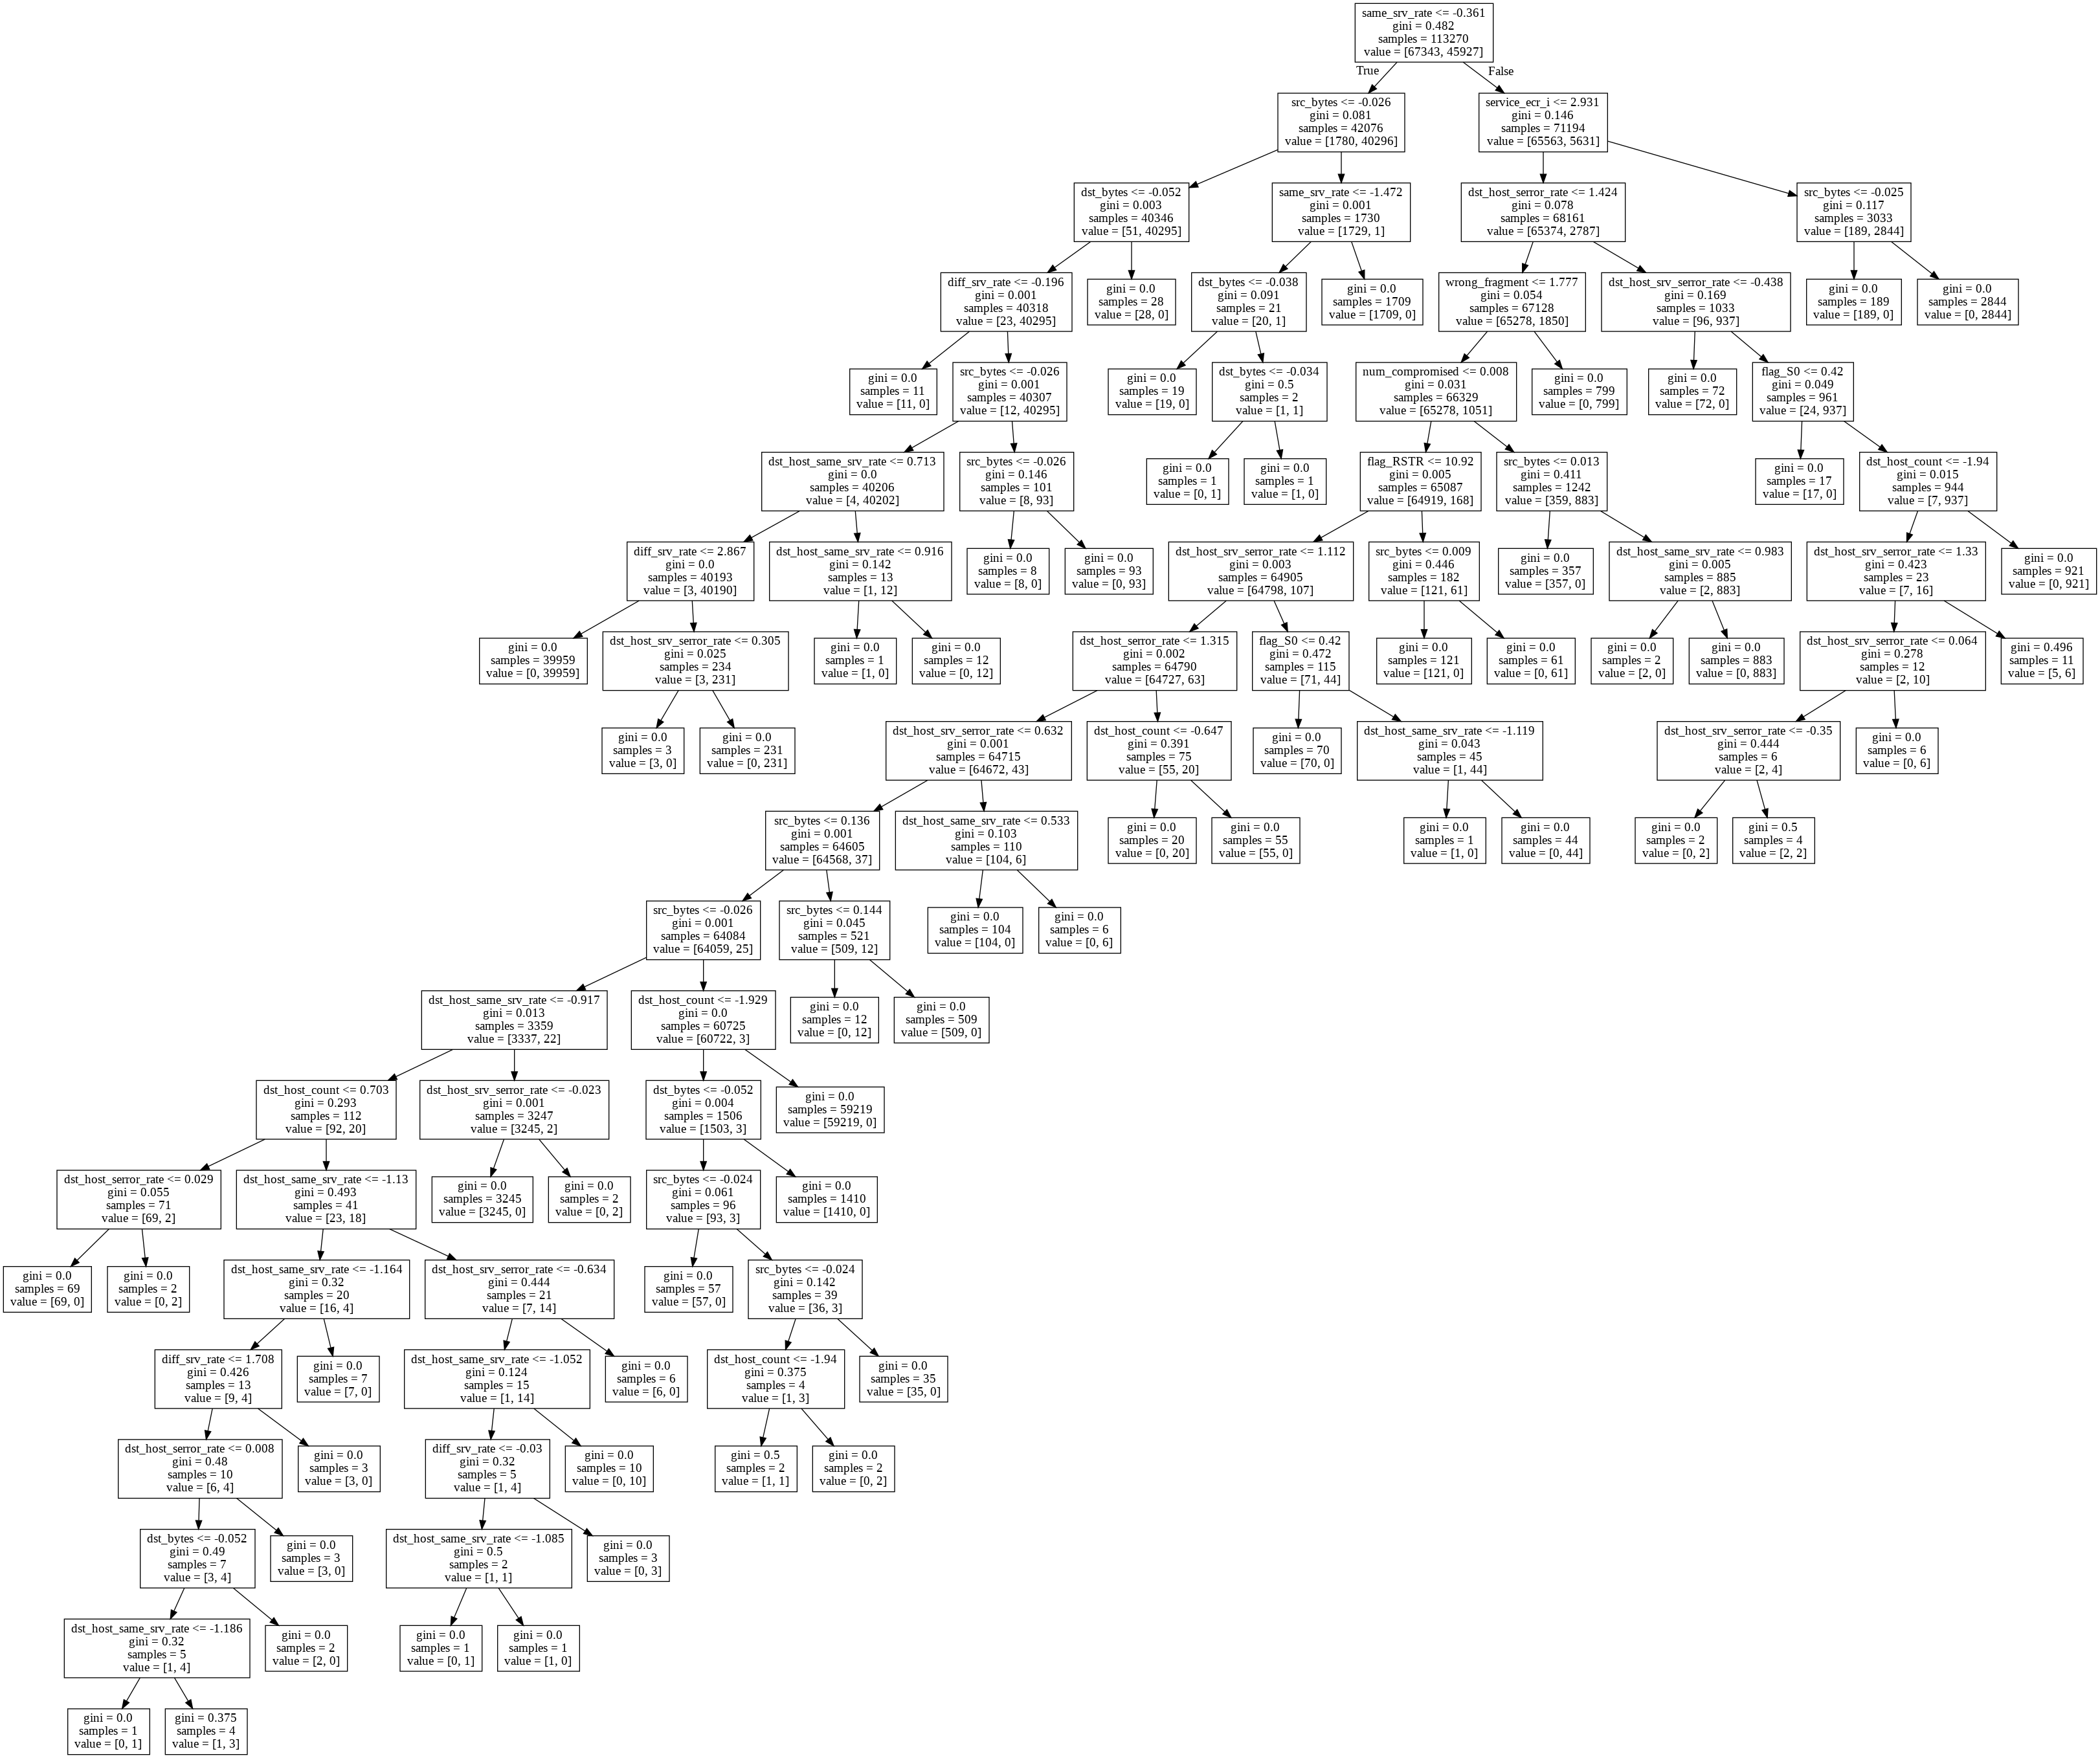

In [ ]:
dot_data = tree.export_graphviz(clf_rfeDoS, out_file=None, 
                                feature_names=rfecolname_DoS)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())